In [1]:
import torch
from torchvision import datasets

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from utils import label2one_hot
from generate_data import generate_data, generate_grid_data
from modules import Dropout
from modules import Linear, Sequential
from modules.losses import LossMSE, LossCrossEntropy
from optimizers import SGD

In [3]:
def convert_to_one_hot_labels(input, target, val=0):
    tmp = input.new(target.size(0), target.max() + 1).fill_(-1)
    tmp.scatter_(1, target.view(-1, 1), 1.0)
    if val == 0:      
        ret = (tmp+1)/2
    if val == -1:
        ret = tmp
    return ret

def load_data(one_hot_labels = False, normalize = False, flatten = True, data_dir = None, cifar = False, full = True, tiny = False, val = 0):

    if data_dir is None:
        """
        data_dir = os.environ.get('PYTORCH_DATA_DIR')
        if data_dir is None:
            data_dir = './data'
        """
        data_dir = './data'
        
    if cifar is not None and cifar:
        print('* Using CIFAR')
        cifar_train_set = datasets.CIFAR10(data_dir + '/cifar10/', train = True, download = True)
        cifar_test_set = datasets.CIFAR10(data_dir + '/cifar10/', train = False, download = True)

        train_input = torch.from_numpy(cifar_train_set.train_data)
        # Dirty hack to handle the change between torchvision 1.0.6 and 1.0.8
        if train_input.size(3) == 3:
            train_input = train_input.transpose(3, 1).transpose(2, 3).float()
        else:
            train_input = train_input.float()
        train_target = torch.LongTensor(cifar_train_set.train_labels)

        test_input = torch.from_numpy(cifar_test_set.test_data).float()
        # Dirty hack to handle the change between torchvision 1.0.6 and 1.0.8
        if test_input.size(3) == 3:
            test_input = test_input.transpose(3, 1).transpose(2, 3).float()
        else:
            test_input = test_input.float()
        test_target = torch.LongTensor(cifar_test_set.test_labels)

    else:
        print('* Using MNIST')
        mnist_train_set = datasets.MNIST(data_dir + '/mnist/', train = True, download = True)
        mnist_test_set = datasets.MNIST(data_dir + '/mnist/', train = False, download = True)

        train_input = mnist_train_set.train_data.view(-1, 1, 28, 28).float()
        train_target = mnist_train_set.train_labels
        test_input = mnist_test_set.test_data.view(-1, 1, 28, 28).float()
        test_target = mnist_test_set.test_labels

    if flatten:
        train_input = train_input.clone().view(train_input.size(0), -1)
        test_input = test_input.clone().view(test_input.size(0), -1)

    if full:
        if tiny:
            raise ValueError('Cannot have both --full and --tiny')
    else:
        if tiny:
            print('** Reduce the data-set to the tiny setup')
            train_input = train_input.narrow(0, 0, 500)
            train_target = train_target.narrow(0, 0, 500)
            test_input = test_input.narrow(0, 0, 100)
            test_target = test_target.narrow(0, 0, 100)
        else:
            print('** Reduce the data-set (use --full for the full thing)')
            train_input = train_input.narrow(0, 0, 1000)
            train_target = train_target.narrow(0, 0, 1000)
            test_input = test_input.narrow(0, 0, 1000)
            test_target = test_target.narrow(0, 0, 1000)

    print('** Use {:d} train and {:d} test samples'.format(train_input.size(0), test_input.size(0)))

    if one_hot_labels:
        train_target = convert_to_one_hot_labels(train_input, train_target, val=val)
        test_target = convert_to_one_hot_labels(test_input, test_target, val=val)

    if normalize:
        mu, std = train_input.mean(), train_input.std()
        train_input.sub_(mu).div_(std)
        test_input.sub_(mu).div_(std)

    return train_input, train_target, test_input, test_target


In [4]:
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True, flatten = True, data_dir = None, cifar = False, full = True, tiny = False, val=0)
train_input_mse, train_target_mse, test_input_mse, test_target_mse = load_data(one_hot_labels = True, normalize = True, flatten = True, data_dir = None, cifar = False, full = True, tiny = False, val=-1)

* Using MNIST
Processing...
Done!
** Use 60000 train and 10000 test samples
* Using MNIST
** Use 60000 train and 10000 test samples


In [5]:
train_target


    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     1     0
[torch.FloatTensor of size 60000x10]

In [6]:
train_target_mse


   -1    -1    -1  ...     -1    -1    -1
    1    -1    -1  ...     -1    -1    -1
   -1    -1    -1  ...     -1    -1    -1
       ...          ⋱          ...       
   -1    -1    -1  ...     -1    -1    -1
   -1    -1    -1  ...     -1    -1    -1
   -1    -1    -1  ...     -1     1    -1
[torch.FloatTensor of size 60000x10]

In [7]:
def default_net_1(x_all, y_all, num_of_neurons=(2, 25, 2), activation='relu', lr=0.1, momentum_coef=0.0, weight_decay=0.0, p_dropout=0.0, num_of_epochs=100, val_split=0.2, verbose=0):
    ce = LossCrossEntropy()

    model = Sequential()
    model.add(Linear(out=num_of_neurons[1], input_size=num_of_neurons[0], activation=activation))
    model.add(Dropout(prob=p_dropout))

    model.add(Linear(out=num_of_neurons[2], activation='softmax'))

    model.loss = ce
    sgd = SGD(lr, momentum_coef, weight_decay=weight_decay)

    report = sgd.train(model, x_all, y_all, num_of_epochs, val_split=val_split, verbose=verbose)

    return model, report

def default_net_2(x_all, y_all, num_of_neurons=(2, 25, 25, 2), activation='relu', lr=0.1, momentum_coef=0.0, weight_decay=0.0, p_dropout=0.0, num_of_epochs=100, val_split=0.2, verbose=0):
    ce = LossCrossEntropy()

    model = Sequential()
    model.add(Linear(out=num_of_neurons[1], input_size=num_of_neurons[0], activation=activation))
    model.add(Dropout(prob=p_dropout))
    model.add(Linear(out=num_of_neurons[2], activation=activation))
    model.add(Dropout(prob=p_dropout))

    model.add(Linear(out=num_of_neurons[3], activation='softmax'))

    model.loss = ce
    sgd = SGD(lr, momentum_coef, weight_decay=weight_decay)

    report = sgd.train(model, x_all, y_all, num_of_epochs, val_split=val_split, verbose=verbose)

    return model, report


def default_net_3(x_all, y_all, num_of_neurons=(2, 25, 25, 25, 2), activation='relu', lr=0.1, momentum_coef=0.0, weight_decay=0.0, p_dropout=0.0, num_of_epochs=100, val_split=0.2, verbose=0):
    ce = LossCrossEntropy()

    model = Sequential()
    model.add(Linear(out=num_of_neurons[1], input_size=num_of_neurons[0], activation=activation))
    model.add(Dropout(prob=p_dropout))
    model.add(Linear(out=num_of_neurons[2], activation=activation))
    model.add(Dropout(prob=p_dropout))
    model.add(Linear(out=num_of_neurons[3], activation=activation))
    model.add(Dropout(prob=p_dropout))
    
    model.add(Linear(out=num_of_neurons[4], activation='softmax'))

    model.loss = ce
    sgd = SGD(lr, momentum_coef, weight_decay=weight_decay)

    report = sgd.train(model, x_all, y_all, num_of_epochs, val_split=val_split, verbose=verbose)

    return model, report

def default_net_4(x_all, y_all, num_of_neurons=(2, 25, 25, 25, 2), lr=0.1, momentum_coef=0.0, weight_decay=0.0, num_of_epochs=100):
    mse = LossMSE()

    model = Sequential()
    model.add(Linear(out=num_of_neurons[1], input_size=num_of_neurons[0], activation='relu'))
    model.add(Dropout(prob=0.2))
    model.add(Linear(out=num_of_neurons[2], activation='relu'))
    model.add(Dropout(prob=0.2))
    model.add(Linear(out=num_of_neurons[3], activation='relu'))
    model.add(Dropout(prob=0.2))
    model.add(Linear(out=num_of_neurons[4], activation='relu'))

    model.loss = mse
    sgd = SGD(lr, momentum_coef, weight_decay=0.0)

    report = sgd.train(model, x_all, y_all, num_of_epochs, val_split=0.2, verbose=0)

    return model, report

In [8]:
def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot(costs, accs, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(costs, label = "test")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(accs, label = "test")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

def plot_v2(train_report, title=""):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(train_report["train_loss"], label = "train")
    ax1.plot(train_report["val_loss"], label = "validation")
    ax2.plot(train_report["train_acc"], label = "train")
    ax2.plot(train_report["val_acc"], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

In [36]:
model1, train1 = default_net_1(train_input, train_target, num_of_neurons=(784, 500, 200, 100, 10), activation='relu', lr=0.1, momentum_coef=0.0, weight_decay=0.0, p_dropout=0.0, num_of_epochs=200, val_split=0.2, verbose=0)
test1 = model1.evaluate(test_input, test_target, return_pred=True)

Added Module Name: 0_Linear 
Added Module Name: 1_ReLU 
Added Module Name: 2_Dropout 
Added Module Name: 3_Linear 
Added Module Name: 4_ReLU 
Added Module Name: 5_Dropout 
Added Module Name: 6_Linear 
Added Module Name: 7_ReLU 
Added Module Name: 8_Dropout 
Added Module Name: 9_Linear 
Added Module Name: 10_Softmax 


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]C:\Users\furkan\Desktop\EPFL\ma\ma2\Deep Learning\project\project2\dl-framework-master\dl-framework-master\modules\losses.py:102: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return loss_val[0]  # TODO: handle this accordingly with take_avg false
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [15:25<00:00,  4.63s/it]


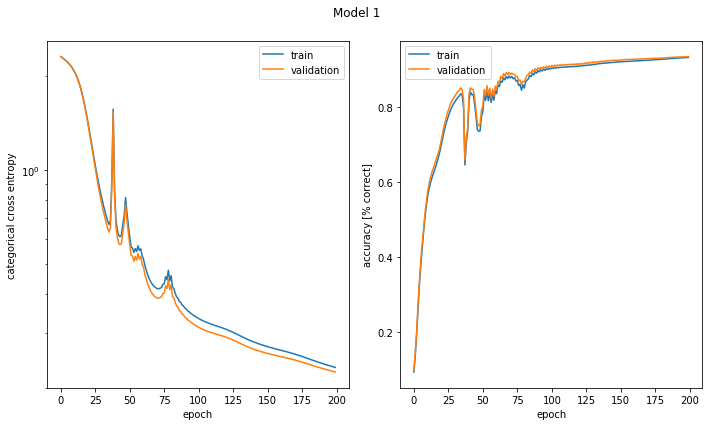

In [37]:
plot_v2(train1, title="Model 1")

In [38]:
test1

(tensor(0.9332), tensor(0.2282), tensor([ 7,  2,  1,  ...,  4,  5,  6]))

In [40]:
test_target[-1,:]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])

In [11]:
model2, train2 = default_net_2(train_input, train_target, num_of_neurons=(784, 100, 100, 10), lr=0.1, momentum_coef=0.0, num_of_epochs=100)
test2 = model2.evaluate(test_input, test_target, return_pred=True)

Added Module Name: 0_Linear 
Added Module Name: 1_ReLU 
Added Module Name: 2_Linear 
Added Module Name: 3_ReLU 
Added Module Name: 4_Linear 
Added Module Name: 5_ReLU 
Added Module Name: 6_Linear 
Added Module Name: 7_Softmax 


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\furkan\Desktop\EPFL\ma\ma2\Deep Learning\project\project2\dl-framework-master\dl-framework-master\modules\losses.py:102: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return loss_val[0]  # TODO: handle this accordingly with take_avg false
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.06s/it]


(tensor(0.9078), tensor(0.3289), tensor([ 7,  2,  1,  ...,  4,  5,  6]))

In [15]:
model3, train3 = default_net_3(train_input_mse, train_target_mse, num_of_neurons=(784, 500, 200, 100, 10), lr=0.1, momentum_coef=0.0, num_of_epochs=100)
test3 = model3.evaluate(test_input_mse, test_target_mse, return_pred=True)

prev: 100, current: 784
Added Module Name: 0_Linear 
Added Module Name: 1_ReLU 
Added Module Name: 2_Dropout 
prev: 100, current: 100
Added Module Name: 3_Linear 
Added Module Name: 4_ReLU 
Added Module Name: 5_Dropout 
prev: 100, current: 100
Added Module Name: 6_Linear 
Added Module Name: 7_ReLU 
Added Module Name: 8_Dropout 
prev: 10, current: 100
Added Module Name: 9_Linear 
Added Module Name: 10_ReLU 


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:23<00:00,  2.04s/it]


(tensor(1.00000e-02 *
        9.8200), tensor(10.), tensor([ 0,  0,  0,  ...,  0,  0,  0]))